## **Set Up**

In [1]:
# import all library
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
import tracemalloc
from scipy.linalg import orth

### Data Preparation

In [2]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


In [3]:
x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

x_subs = [x_sub1, x_sub2, x_sub3, x_sub4]
y_subs = [y_sub1, y_sub2, y_sub3, y_sub4]

## Additional Functions

In [4]:
def get_mean_cov_mat(x_train):
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)
    A = x_train - x_train_bar
    S = np.matmul(A, A.T) / A.shape[1]
    return x_train_bar, S

In [5]:
def pca_egidecom_runtime_memory_measure(n_components, x_train):
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)
    A = x_train - x_train_bar
    S = np.matmul(A, A.T) / A.shape[1]

    # Measure only eigen-decomposition
    tracemalloc.start()
    start_time = time.perf_counter()

    eigvals, eigvecs = np.linalg.eigh(S)

    run_time = time.perf_counter() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]

    P = eigvecs[:, :n_components]

    return P, run_time, peak_memory

In [6]:
def update_P(n_components, P_origin, x_sub_origin, x_sub_new, x_origin_bar, check_only_update_time=False):
    if check_only_update_time:
        P_new, _, _ = pca_egidecom_runtime_memory_measure(n_components, x_sub_new)
        run_time, peak_memory_sub = 0, 0        
    else:
        P_new, run_time, peak_memory_sub = pca_egidecom_runtime_memory_measure(n_components, x_sub_new)

    # Get Phi matrix
    x_new_bar = np.average(x_sub_new, axis=1).reshape(-1,1)
    combined_matrix = np.hstack((P_origin, P_new, x_origin_bar - x_new_bar))
    Phi = orth(combined_matrix) 

    # Get Rotation matrix
    combined_x = np.concatenate((x_sub_origin, x_sub_new), axis=1)
    x_bar_new, S_2 = get_mean_cov_mat(combined_x)

    # Measure only eigen-decomposition
    S_new = Phi.T @ S_2 @ Phi
    
    tracemalloc.start()
    start_time = time.perf_counter()

    eigvals, eigvecs = np.linalg.eigh(S_new)

    run_time += time.perf_counter() - start_time
    _, peak_memory_S = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]

    R = eigvecs[:, :n_components]
    P_updated = Phi@R
    
    return P_updated, combined_x, x_bar_new, run_time, max(peak_memory_sub, peak_memory_S)

In [7]:
def ipca_nn(n_components, x_subs, y_train, x_test, y_test, x_sub1=None, check_only_update_time=False):
    x1_bar = np.average(x_subs[0], axis=1).reshape(-1,1)
    if check_only_update_time:
        P1, run_time, peak_memory = pca_egidecom_runtime_memory_measure(n_components, x_subs[0])
    else:
        P1, _, _ = pca_egidecom_runtime_memory_measure(n_components, x_subs[0])
        run_time, peak_memory = 0, 0

    # Incrementally merge each eigenvectors
    P2, combined_x_2, x2_bar, run_time2, peak_memory2 = update_P(n_components, P1, x_subs[0], x_subs[1], x1_bar, check_only_update_time)
    run_time += run_time2
    peak_memory = max(peak_memory, peak_memory2)

    P3, combined_x_3, x3_bar, run_time3, peak_memory3 = update_P(n_components, P2, combined_x_2, x_subs[2], x2_bar, check_only_update_time)
    run_time += run_time3
    peak_memory = max(peak_memory, peak_memory3)

    P4, combined_x_4, x4_bar, run_time4, peak_memory4 = update_P(n_components, P3, combined_x_3, x_subs[3], x3_bar, check_only_update_time)
    run_time += run_time4
    peak_memory = max(peak_memory, peak_memory4)

    # Get reconstruction error
    A_test = x_test - x4_bar
    W_test = np.matmul(P4.T, A_test)
    x_test_rec = x4_bar + np.matmul(P4, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))


    # Applying NN algorithm
    x_train_proj = np.matmul(P4.T, x_train - x4_bar)
    x_test_proj = np.matmul(P4.T, x_test - x4_bar)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)

    return accuracy, rec_err, run_time, peak_memory

In [8]:
def pca_nn(n_components, x_train, y_train, x_test, y_test, x_sub1=None, check_only_update_time=False):
    pca = PCA(n_components=n_components)
    
    if x_sub1 is None:
        P, run_time, peak_memory = pca_egidecom_runtime_memory_measure(n_components, x_train)

    else:
        P, run_time, peak_memory = pca_egidecom_runtime_memory_measure(n_components, x_sub1)

    # Get mean vector
    x_train_bar = np.average(x_train, axis=1).reshape(-1,1)

    # Get reconstruction error
    A_test = x_test - x_train_bar
    W_test = np.matmul(P.T, A_test)
    x_test_rec = x_train_bar + np.matmul(P, W_test)
    rec_err = np.mean(np.abs(x_test - x_test_rec))


    # Applying NN algorithm
    x_train_proj = np.matmul(P.T, x_train - x_train_bar)
    x_test_proj = np.matmul(P.T, x_test - x_train_bar)

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))

    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)
    accuracy = accuracy_score(y_test.T, y_pred)

    return accuracy, rec_err, run_time, peak_memory

In [9]:
def print_results(accuracy, rec_err, run_time, peak_memory):
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Reconstruction Error with eigenvectors (MAE): {rec_err:.3f}")
    print(f"Peak memory usage: {peak_memory / 10**6:.8f} MB")
    print(f"Execution Time: {run_time:.6f} seconds")

In [10]:
# Get Average Result
def avg_results(num_iter, func, num_bases, x_train, y_train, x_test, y_test, x_sub1=None, check_only_update_time=False):
    accuracy_avg, rec_err_avg, run_time_avg, peak_memory_avg = 0,0,0,0

    for i in range(num_iter):
        accuracy, rec_err, run_time, peak_memory = func(num_bases, x_train, y_train, x_test, y_test, x_sub1, check_only_update_time)
    
        accuracy_avg += accuracy
        rec_err_avg += rec_err
        run_time_avg += run_time
        peak_memory_avg += peak_memory
    
    accuracy_avg /= num_iter
    rec_err_avg /= num_iter
    run_time_avg /= num_iter
    peak_memory_avg /= num_iter

    return accuracy_avg, rec_err_avg, run_time_avg,  peak_memory_avg

## **Q2. Incremental PCA**

### Incremental PCA

In [11]:
accuracy, rec_err, run_time, peak_memory = ipca_nn(30, x_subs, y_train, x_test, y_test, check_only_update_time=False)

print_results(accuracy, rec_err, run_time, peak_memory)

Accuracy: 63.46%
Reconstruction Error with eigenvectors (MAE): 13.540
Peak memory usage: 53.10810600 MB
Execution Time: 2.165605 seconds


### Batch PCA

In [12]:
accuracy, rec_err, run_time, peak_memory = pca_nn(30, x_train, y_train, x_test, y_test)

print_results(accuracy, rec_err, run_time, peak_memory)

Accuracy: 64.42%
Reconstruction Error with eigenvectors (MAE): 13.472
Peak memory usage: 53.10881800 MB
Execution Time: 0.761692 seconds


### Sub1 PCA

In [13]:
accuracy, rec_err, run_time, peak_memory = pca_nn(30, x_train, y_train, x_test, y_test, x_sub1)

print_results(accuracy, rec_err, run_time, peak_memory)

Accuracy: 57.69%
Reconstruction Error with eigenvectors (MAE): 16.749
Peak memory usage: 53.10881800 MB
Execution Time: 0.703387 seconds


### Get overall Results with average values

In [14]:
interval = 5
num_iter = 5

num_base_vecs = []

ipca_acc_result, batch_acc_result, sub1_acc_result = [], [], []
ipca_rec_err_result, batch_rec_err_result, sub1_rec_err_result = [], [], []
ipca_runtime_result, batch_runtime_result, sub1_runtime_result = [], [], []
ipca_peak_mem_result, batch_peak_mem_result, sub1_peak_mem_result = [], [], []


for i in range(1, 21):
    num_bases = interval*i
    num_base_vecs.append(num_bases)
    
    # Get each PCA result
    ipca_accuracy, ipca_rec_err, ipca_run_time, ipca_peak_memory = avg_results(num_iter, ipca_nn, num_bases, x_subs, y_train, x_test, y_test, check_only_update_time=True)
    batch_accuracy, batch_rec_err, batch_run_time, batch_peak_memory = avg_results(num_iter, pca_nn, num_bases, x_train, y_train, x_test, y_test)
    sub1_accuracy, sub1_rec_err, sub1_run_time, sub1_peak_memory = avg_results(num_iter, pca_nn, num_bases, x_train, y_train, x_test, y_test, x_sub1)

    # accuracy arrays
    ipca_acc_result.append(ipca_accuracy)
    batch_acc_result.append(batch_accuracy)
    sub1_acc_result.append(sub1_accuracy)

    # reconstruction error arrays
    ipca_rec_err_result.append(ipca_rec_err)
    batch_rec_err_result.append(batch_rec_err)
    sub1_rec_err_result.append(sub1_rec_err)

    # runtime arrays -> seconds
    ipca_runtime_result.append(ipca_run_time)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)
    

    # peak memory arrays -> Mega Bite (MB)
    ipca_peak_mem_result.append(ipca_peak_memory / (1024**2))
    batch_peak_mem_result.append(batch_peak_memory / (1024**2))
    sub1_peak_mem_result.append(sub1_peak_memory / (1024**2))

KeyboardInterrupt: 

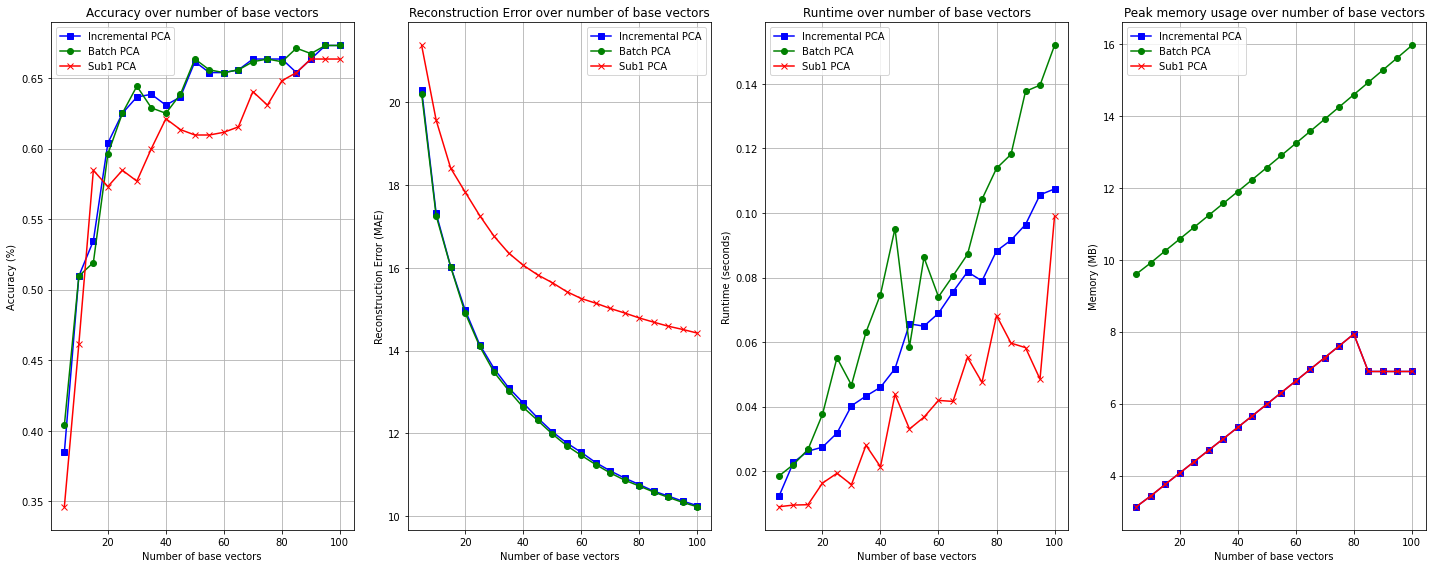

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, ipca_acc_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_acc_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_acc_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy over number of base vectors')
axes[0].legend()
axes[0].grid(True)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, ipca_rec_err_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_rec_err_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_rec_err_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors')
axes[1].set_ylabel('Reconstruction Error (MAE)')  # Customize based on your runtime units
axes[1].set_title('Reconstruction Error over number of base vectors')
axes[1].legend()
axes[1].grid(True)

# Plot runtime on the second subplot
axes[2].plot(num_base_vecs, ipca_runtime_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[2].plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[2].plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[2].set_xlabel('Number of base vectors')
axes[2].set_ylabel('Runtime (seconds)')  # Customize based on your runtime units
axes[2].set_title('Runtime over number of base vectors')
axes[2].legend()
axes[2].grid(True)

# Plot Peak memory usage on third subplot
axes[3].plot(num_base_vecs, ipca_peak_mem_result, label='Incremental PCA', marker='s', linestyle='-', color='b')
axes[3].plot(num_base_vecs, batch_peak_mem_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[3].plot(num_base_vecs, sub1_peak_mem_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[3].set_xlabel('Number of base vectors')
axes[3].set_ylabel('Memory (MB)')  # Customize based on your runtime units
axes[3].set_title('Peak memory usage over number of base vectors')
axes[3].legend()
axes[3].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()